### Multiround UNL Attack Trimmed Mean other attacks

Feb 1 2024
TJ Kim

##### Summary
Load FAT model trained for 150 rounds and for 50 rounds try and inject FedAvg model into the system. Try different scaling rates and spread out the model replacement attack.

Against trimmed mean defense we test other poisoning attacks with the following method
- Label flip attack, all aru clients simply shift 1 label down (-1)
- Random Noise attack, all aru clients generate random noise between 1 and -1 and boost accordintly

In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

In [3]:
setting, num_user = "FedAvg_adv", 40

try: # Skip loading if already loaded
    aggregator
except:
    aggregator, clients, args_ = set_args(setting, num_user)

# Load models for FAT and FedAvg
save_path_FAT = 'weights/cifar10/230922_baseline_train/FAT/'
save_path_FedAvg = 'weights/cifar10/230922_baseline_train/fedavg/'

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator, args_)[0])
model_Fedavg = import_model_weights(num_user, setting, save_path_FedAvg, aggregator, args_)[0]


==> Clients initialization..
===> Building data iterators..


100%|██████████| 80/80 [00:00<00:00, 161.89it/s]


===> Initializing clients..


100%|██████████| 80/80 [00:37<00:00,  2.15it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


In [4]:
# Obtain parameters for each layer
params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Just take the values of weights and bias for the model
desired_keys = [key for key in params_FAT.keys() if 'weight' in key or 'bias' in key]

In [12]:
torch.min(params_FAT[desired_keys[0]])

tensor(-0.9771, device='cuda:0')

In [20]:
model_global = model_FAT 
keys = desired_keys


global_state_dict = model_global.state_dict(keep_vars=True)
return_state_dict = copy.deepcopy(global_state_dict)

for key in keys:
    max_temp =  torch.max(global_state_dict[key].data)
    min_temp = torch.min(global_state_dict[key].data)
    global_shape = global_state_dict[key].shape
    return_state_dict[key].data = (max_temp-min_temp)* torch.rand(global_shape).to('cuda') + min_temp 


In [27]:
# Calculate uploaded model and download to attacker clients in aggregator
# Current version working under the assumption of close to convergence (no benign client pushback)
def calc_noise_atk_model(model_global, keys, weight_scale_2 =1):

    model_global = model_FAT 
    keys = desired_keys

    atk_model = copy.deepcopy(model_global)
    global_state_dict = model_global.state_dict(keep_vars=True)
    return_state_dict = atk_model.state_dict(keep_vars=True)

    for key in keys:
        max_temp =  torch.max(global_state_dict[key].data)
        min_temp = torch.min(global_state_dict[key].data)
        global_shape = global_state_dict[key].shape
        return_state_dict[key].data = weight_scale_2 * ((max_temp-min_temp)* torch.rand(global_shape).to('cuda') + min_temp)

    return atk_model

def manipulate_client_data():

    return

# Expand aggregator.mix() function
def UNL_mix_otheratk(aggregator, adv_id, keys, atk_type, weight_scale_2 = 1, dump_flag=False, aggregation_op = None, tm_beta = 0.05, class_count = 10):
    # weight_scale = 1/aggregator.clients_weights
    model_global = aggregator.global_learners_ensemble[0].model

    if aggregation_op == None:
        aggregation_op = aggregator.aggregation_op

    # Give adversarial clients boosted models and train regular clients 1 round
    benign_id = list(range(len(aggregator.clients)))

    if atk_type == "label_flip":
        for a_id in adv_id:
            # Must change class-count for other data sets
            aggregator.clients[a_id].swap_dataset_labels(class_count = class_count, switch_pair=False)
    elif atk_type == "noise":
        for a_id in adv_id:
            benign_id.remove(a_id)
            temp_atk_model = calc_noise_atk_model(model_global, keys, weight_scale_2)
            aggregator.clients[a_id].learners_ensemble[0].model = copy.deepcopy(temp_atk_model)
    else: 
        raise ValueError('Poison Attack not properly chosen [label_flip, noise]') 

    

    for c_id in benign_id:
        aggregator.clients[c_id].step()

    # Aggregate model and download
    for learner_id, learner in enumerate(aggregator.global_learners_ensemble):
        learners = [client.learners_ensemble[learner_id] for client in aggregator.clients]
        if aggregation_op is None:
            average_learners(learners, learner, weights=aggregator.clients_weights)
        elif aggregation_op == 'median':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_median.pkl") 
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_median(
                learners, 
                learner, 
                dump_path=dump_path
            )
        elif aggregation_op == 'trimmed_mean':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_tm.pkl")
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_tm(
                learners, 
                learner, 
                beta=tm_beta, 
                dump_path=dump_path
            )
        elif aggregation_op == 'krum':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_krum.pkl")
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_krum(
                learners, 
                learner, 
                dump_path=dump_path
            )
        elif aggregation_op == 'krum_modelwise':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_krum_modelwise.pkl")
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_krum_modelwise(
                1,
                learners,
                learner,
                dump_path=dump_path
            )
        else:
            raise NotImplementedError


    # assign the updated model to all clients
    aggregator.update_clients()

    aggregator.c_round += 1

    return 



In [32]:
beta_params = [0.2,0.2]
agg_op_list = ["trimmed_mean", "trimmed_mean"]
num_aru = [10,10]
weight2_list = [1,1]
atype = ['label_flip', 'noise']

Fu_count = [15,15,15]
G_count = [0.7,0.7,0.7]

num_rounds = 20
num_class = 10 # cifar 10

result_list = []
for itt in range(len(beta_params)):
    result_list += [{}]

setting, num_user = "FedAvg_adv", 40
save_path_FedAvg_150R = 'weights/cifar10/231031_FAT150round/FAT'
aggregator, clients, args_ = set_args(setting, num_user)



for itt in range(len(beta_params)):
    print("updating adv data set")
    Fu = np.zeros(num_user)
    Fu[0:Fu_count[itt]] = 1 * G_count[itt]

    aggregator.aggregation_op = agg_op_list[itt]

    # Setting evasion attack parameters
    x_min = torch.min(clients[0].adv_nn.dataloader.x_data)
    x_max = torch.max(clients[0].adv_nn.dataloader.x_data)
    atk_params = PGD_Params()
    atk_params.set_params(batch_size=1, iteration = 10,
                    target = -1, x_val_min = x_min, x_val_max = x_max,
                    step_size = 0.05, step_norm = "inf", eps = 4.5, eps_norm = 2)

    # Assign proportion and attack params
    for c in range(len(clients)):
        if Fu[c] > 0:
            aggregator.clients[c].set_adv_params(Fu[c], atk_params)
            aggregator.clients[c].update_advnn()
            aggregator.clients[c].assign_advdataset()

    # Perform 50 rounds of FAT on FedAvg model 
    num_adv = num_aru[itt]
    weight2 = weight2_list[itt]
    adv_id = random.sample(range(Fu_count[itt],num_user), num_adv) # excluding 0-9 as Fu = 1
    beta = beta_params[itt]

    test_acc_gather = []
    adv_acc_gather = []
    test_acc_std = []
    adv_acc_std = []

    aggregator.tm_rate = beta

    # Test performance of aggregator on data 
    aggregator.load_state(dir_path = save_path_FedAvg_150R)
    aggregator.update_clients()
    model_FA = pull_model_from_agg(aggregator)
    model_FA.eval()
    acc, adv_acc = get_adv_acc(aggregator, model_FA)

    prev_model = copy.deepcopy(model_FA)

    print("Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))
    test_acc_gather+= [np.mean(acc)]
    adv_acc_gather += [np.mean(adv_acc)]
    test_acc_std += [np.std(acc)]
    adv_acc_std += [np.std(adv_acc)]



    for i in range(num_rounds):

        # Per round Freq

        # aggregator.mix()
        UNL_mix_otheratk(aggregator, adv_id, keys = desired_keys, atk_type = atype[itt], weight_scale_2 = weight2, dump_flag=False, tm_beta=beta, class_count = num_class)
        model_overfit = pull_model_from_agg(aggregator)
        model_overfit.eval()
        acc, adv_acc = get_adv_acc(aggregator, model_overfit)

        print("round", i,"Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))
        test_acc_gather+= [np.mean(acc)]
        adv_acc_gather += [np.mean(adv_acc)]
        test_acc_std += [np.std(acc)]
        adv_acc_std += [np.std(adv_acc)]
        prev_model = copy.deepcopy(model_overfit)

        result_list[itt]['test_acc'] = copy.deepcopy(test_acc_gather)
        result_list[itt]['adv_acc'] = copy.deepcopy(adv_acc_gather)
        result_list[itt]['test_std'] = copy.deepcopy(test_acc_std)
        result_list[itt]['adv_std'] = copy.deepcopy(adv_acc_std)
        result_list[itt]['num_clients'] = num_adv
        result_list[itt]['beta'] = beta
        result_list[itt]['poison_type'] = atype[itt]
        # Perform gradient direction gathering

    

==> Clients initialization..
===> Building data iterators..


100%|██████████| 80/80 [00:00<00:00, 223.85it/s]


===> Initializing clients..


100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


updating adv data set
Test acc:  0.7934375122189522 adv acc:  0.3406250044703484
round 0 Test acc:  0.7990625113248825 adv acc:  0.31656250581145284
round 1 Test acc:  0.7968750149011612 adv acc:  0.28968750573694707
round 2 Test acc:  0.7900000125169754 adv acc:  0.27062500491738317
round 3 Test acc:  0.7959375157952309 adv acc:  0.257812506519258
round 4 Test acc:  0.8003125131130219 adv acc:  0.24187500290572644
round 5 Test acc:  0.8075000137090683 adv acc:  0.24125000573694705
round 6 Test acc:  0.8068750113248825 adv acc:  0.24000000655651094
round 7 Test acc:  0.8040625095367432 adv acc:  0.2315625024959445
round 8 Test acc:  0.7934375137090683 adv acc:  0.2346875049173832
round 9 Test acc:  0.8025000154972076 adv acc:  0.22781250327825547
round 10 Test acc:  0.8025000140070915 adv acc:  0.23187500461935998
round 11 Test acc:  0.7950000122189522 adv acc:  0.2203125063329935
round 12 Test acc:  0.7978125080466271 adv acc:  0.2278125047683716
round 13 Test acc:  0.7990625113248825

In [34]:
import pickle

a = result_list

with open('saved_results/poison_sweep/240201_02_vanilla_yestm.pk', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [47]:
# load relevant information and plot 
# plot_settings = [[5, 0.05, 0.3],[5, 0.1, 0.2],[5, 0.2, 0.1],[10, 0.2, 0.15]] # [num_aru, tm_param, scale]
plot_settings = ["FAT Client = 30", "FAT Client = 15", "FAT Client = 10"]
adv_acc_plotter = []
adv_std_plotter = []

# LINE NO 1
with open('saved_results/poison_sweep/240201_01_vanilla_notm.pk', 'rb') as handle:
    loaded = pickle.load(handle)
adv_acc_plotter += [loaded[0]["adv_acc"]]
adv_std_plotter += [loaded[0]["adv_std"]]

adv_acc_plotter += [loaded[1]["adv_acc"]]
adv_std_plotter += [loaded[1]["adv_std"]]

# adv_acc_plotter += [loaded[2]["adv_acc"]]
# adv_std_plotter += [loaded[2]["adv_std"]]


IndexError: list index out of range

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


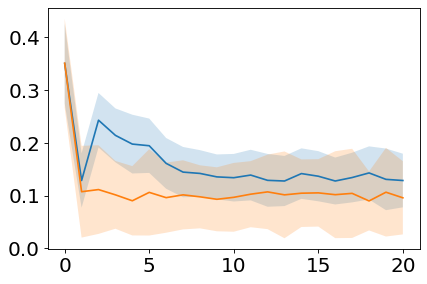

In [31]:
import matplotlib.pyplot as plt
import numpy as np

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.figure(dpi=80, figsize=(6,4))

# Generate some sample data
x = range(len(adv_acc_plotter[0]))  # 100 points from 0 to 10

# Plotting the lines
# plt.plot(x, y1, label='Test Acc')
label_list = plot_settings
for i in range(len(label_list)):
    y = np.array(adv_acc_plotter[i])
    error = np.array(adv_std_plotter[i])
    plt.plot(x, y, label= str(label_list[i]))
    plt.fill_between(x, y-error, y+error,
    alpha=0.2)

# Adding labels and title
plt.xlabel('Injection Rounds')
plt.ylabel('Adv. Acc. (Robustness)')
plt.title('Trimmed Mean and FAT Distribution \n [tm_param = 0.2, scale = 0.2]', fontsize = 'medium')

# Adding a legend
plt.legend( loc=1, fontsize='x-small')

# Display the plot
plt.show()


In [57]:
result_list[1]['adv_std']

[0.07080383651981387,
 0.04910825698149192,
 0.06756868617547655,
 0.0650413037059303,
 0.06213644349849114,
 0.05066356558232572,
 0.05588422702186104,
 0.05587985939243361,
 0.05102082989949116,
 0.05509579789542937,
 0.06135195729639833,
 0.05331217160974913,
 0.04983958901338353,
 0.054878239433493375,
 0.06568078302051979,
 0.059054234079000685,
 0.05651932272193579,
 0.051124082337580555,
 0.05645708549827587,
 0.05423833432493763,
 0.05686384040804998]

In [45]:
adv_acc_plotter[1]

NameError: name 'test_acc_plotter' is not defined